In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

# Backward Propagation

<img src="./images/Layer_dim.png" alt="示例图片" width="1100">

In [2]:
# 生成权重以及偏置项，layers_dim 代表每层的神经元个数
# 比如 [2, 3, 1] 代表一个三层的网络，输入为 2 层，中间为 3 层，输出为 1 层
def init_parameters(layers_dim):
    L = len(layers_dim)
    parameters = {}
    for i in range(1, L):
        parameters["w"+str(i)] = np.random.random([layers_dim[i], layers_dim[i-1]]) # i-1 到 i 层的权重
        # 生成一个形状为 [layers_dim[i], layers_dim[i-1]] 的随机数组。
        # layers_dim[i]：第 i 层的节点数。
        # layers_dim[i-1]：第 i-1 层的节点数。
        parameters["b"+str(i)] = np.zeros((layers_dim[i], 1))
        
    return parameters

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# sigmoid 的导函数
def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

# 前向传播，需要用到一个输入 x 以及所有的权重以及偏置项，都在 parameters 这个字典里面存储
# 最后会返回一个 caches，里面包含的是各层的激活值 a 和 z，a[layers]就是最终的输出
def forward(x, parameters):
    a = []
    z = []
    caches = {}
    a.append(x)
    z.append(x)
    layers = len(parameters) // 2 # 因为有 w，b
    
    # 前面都要用 sigmoid
    for i in range(1, layers):
        # parameters["w" + str(i)]: i-1 到 i 层的权重
        # z_temp = parameters["w" + str(i)].dot(x) + parameters["b" + str(i)]
        z_temp = parameters["w" + str(i)].dot(a[i - 1]) + parameters["b" + str(i)]
        z.append(z_temp)
        a.append(sigmoid(z_temp))
        
    # 最后一层不用sigmoid
    z_temp = parameters["w" + str(layers)].dot(a[layers - 1]) + parameters["b" + str(layers)]
    z.append(z_temp)
    a.append(z_temp)
    
    caches["z"] = z
    caches["a"] = a
    return caches, a[layers]

<img src="./images/bpL.png" alt="示例图片" width="600"><img src="./images/bp_graph.png" alt="示例图片" width="300">
<img src="./images/bp.png" alt="示例图片" width="1100">

In [3]:
# 反向传播，parameters 里面存储的是所有的各层的权重以及偏置，caches 里面存储各层的 a 和 z
# al 是经过反向传播后最后一层的输出，y 代表真实值
# 返回的 grades 代表着误差对所有的 w 以及 b 的导数
def backward(parameters, caches, al, y):
    layers = len(parameters) // 2 # 因为有 w，b
    grades = {}
    m = y.shape[1] # 样本数
    # 假设最后一层无激活函数
    grades["dz" + str(layers)] = al - y
    # 第 layers - 1 层到第 layers 层的 dw 和 db
    grades["dw" + str(layers)] = grades["dz" + str(layers)].dot(caches["a"][layers - 1].T) / m # 平均误差
    # 公式中求对 b^l 的梯度，乘的是1(因为 z^l+1 对 b^l 求导为1)，实际上是一个全为 1 的向量，所以这里直接是求和
    grades["db" + str(layers)] = np.sum(grades["dz" + str(layers)], axis=1, keepdims=True) / m
    # axis=1表示沿着数组的第二个维度（通常是列）求和。
    # keepdims=True参数确保求和后的结果仍然保持原有的维度数，只是相关维度的大小变为1。
    
    # 前面全部都是 sigmoid 激活函数
    for i in reversed(range(1, layers)):
        # w^i: [layers_dim[i], layers_dim[i-1]] <- 记录在 parameters["w"+str(i+1)] 中
        # dz^i: [layers_dim[i], 1]
        # dz^i-1: [layers_dim[i-1], 1] = w^i.T * dz^i
        # *: 对应元素相乘
        grades["dz" + str(i)] = parameters["w"+str(i+1)].T.dot(grades["dz" + str(i+1)]) * sigmoid_derivative(caches["z"][i])
        # dz^i: [layers_dim[i], 1]
        # caches["a"][i-1]: [1, layers_dim[i]]
        grades["dw" + str(i)] = grades["dz" + str(i)].dot(caches["a"][i - 1].T) / m
        grades["db" + str(i)] = np.sum(grades["dz" + str(i)], axis=1, keepdims=True) / m
    return grades

Gradient Descent:

$$
w(t+1) = w(t) − η \frac{∂L}{∂w}
$$

In [4]:
# 就是把其所有的权重以及偏置都更新一下
def update_grades(parameters, grades, learning_rate):
    layers = len(parameters) // 2
    for i in range(1, layers + 1):
        parameters["w" + str(i)] -= learning_rate * grades["dw" + str(i)]
        parameters["b" + str(i)] -= learning_rate * grades["db" + str(i)]
    return parameters

# 计算误差值
def compute_loss(al, y):
    return np.mean(np.square(al - y))

204.9553547123235
30.101349691933482
21.32465649131606
11.636995328873688
5.419777424601469
9.482228768955096
5.23489113040173
3.638450666094785
2.685238586558259
2.0727011221330014
1.6524529346466001
1.3473134565567124
1.1201670308674547
0.9505703080315534
0.8241559406266044
0.7304268602178584
0.6616262927006731
0.6116052835670845
0.575173605574598
0.5481780616234534
0.5277448248751997
0.5121157909496444
0.5001839542329894
0.49113512833906886
0.48432440096892504
0.47925365526909613
0.4755395201860101
0.47287313580122814
0.47100012932452434
0.46971637170340225
0.4688614507250588
0.4683072605560007
0.4679498573528605
0.4677068109542127
0.46751526916915337
0.4673280490497131
0.4671097485842578
0.46683472376276874
0.46648598679533926
0.4660535973847443


<function matplotlib.pyplot.show(close=None, block=None)>

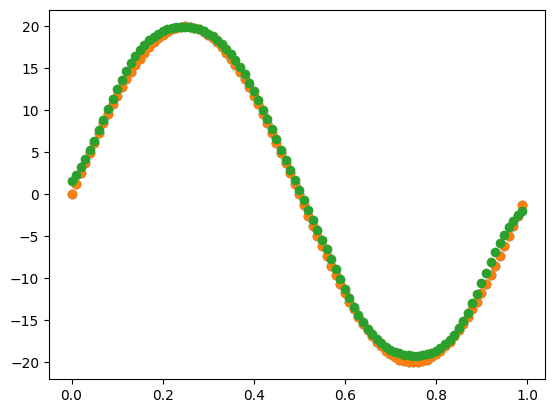

In [5]:
# 加载数据
def load_data():
    x = np.arange(0.0, 1.0, 0.01)
    y = 20 * np.sin(2 * np.pi * x)
    # 数据可视化
    plt.scatter(x, y)
    return x, y

# 进行测试
x, y = load_data()
x = x.reshape(1, 100)
y = y.reshape(1, 100)
plt.scatter(x, y)
parameters = init_parameters([1, 6, 1])
al = 0
for i in range(4000):
    caches, al = forward(x, parameters)
    grades = backward(parameters, caches, al, y)
    parameters = update_grades(parameters, grades, learning_rate=0.3)
    if i % 100 == 0:
        print(compute_loss(al, y))
plt.scatter(x, al)
plt.show

# CNN

<img src="./images/CNN.png" alt="示例图片" width="1100">

In [6]:
def conv2d(img, in_channels, out_channels, kernels, bias, stride=1, padding=0):
    # stride 步长
    N, C, H, W = img.shape
    kh, kw = kernels.shape
    p = padding
    # assert expression, "Error message"
    assert C == in_channels, "kernels' input channels do not match with img"
    
    if p:
        img = np.pad(img, ((0, 0), (0, 0), (p, p), (p, p))) # padding along with all axis
        # 不对 batch_size 维度和 channels 维度进行填充。
        # (p, p)：对 height 和 width 维度进行填充，前后各填充 p 个元素。
        
    out_h = (H + 2*padding - kh) // stride + 1
    out_w = (W + 2*padding - kw) // stride + 1
    outputs = np.zeros([N, out_channels, out_h, out_w])
    # print(img)
    for n in range(N):
        for out in range(out_channels):
            for i in range(in_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        for x in range(kh):
                            for y in range(kw):
                                outputs[n][out][h][w] += img[n][i][h*stride + x][w*stride + y] * kernels[x][y]
                                
                if i == in_channels - 1:
                    outputs[n][out][:][:] += bias[n][out]
    return outputs

In [7]:
# CNN 模型
class CNNNet(torch.nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        # 两个卷积层
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5) # 1 为 in_channels，10 为 out_channels
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        # 池化层
        self.pooling = torch.nn.MaxPool2d(2) # 2 为分组大小 2*2
        # 全连接层 320 = 20 * 4 * 4
        self.fc = torch.nn.Linear(320, 10)
        
    def forward(self, x):
        # 先从 x 数据维度中得到 batch_size
        batch_size = x.size(0)
        # 卷积层 -> 池化层 -> 激活函数
        x = F.relu(self.pooling(self.conv1(x)))
        x = F.relu(self.pooling(self.conv2(x)))
        x = x.view(batch_size, -1) # 将数据展开，为全连接层做准备
        x = self.fc(x)
        return x
    
model = CNNNet()

# RNN

<img src="./images/RNN.png" alt="示例图片" width="300">

In [8]:
class Rnn(nn.Module):
    def __init__(self, input_size):
        super(Rnn, self).__init__()
        # 定义RNN网络
        # hidde_size 是自己设置的，貌似取值都是 32, 64, 128 这样来取值
        # num_layers 是隐藏层数量，超过 2 层那就是深度循环神经网络了
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=32,
            num_layers=1,
            batch_first=True # 输入形状为 [批量大小，数据序列长度，特征维度]
        )
        # 定义全连接层
        self.out = nn.Linear(32, 1)
        
    # 定义前向传播函数
    def forward(self, x, h_0):
        r_out, h_n = self.rnn(x, h_0)
        # print(r_out)
        # print(h_n)
        # print(r_out.size(), h_n.size())
        outs = []
        for time in range(r_out.size(1)):
            print(r_out[:, time, :])
            # 依次抽取序列中的每个单词，将之痛过全连接层并输出.r_out[:, 0, :].size()=[1, 32] -> [1, 1]
            outs.append(self.out(r_out[:, time, :]))
            print(outs)
        
        # stack 函数在 dim=1 上叠加：10*[1, 1] -> [1, 10, 11] 同时 h_n 已经被更新
        return torch.stack(outs, dim=1), h_n
        

In [9]:
TIME_STEP =  10
INPUT_SIZE = 1
LR = 0.02
model = Rnn(INPUT_SIZE)
print(model)
# 构造输入数据，长度为 TIME_STEP，特征维度为 INPUT_SIZE
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # 长度为 10 的输入数据
x = torch.tensor(x, dtype=torch.float32).view(1, -1, INPUT_SIZE)  # 转换为 [batch_size=1, seq_len=10, input_size=1]

# 初始化隐藏状态 h_0
h_0 = torch.zeros(1, 1, 32)  # 1 个层, 1 个样本, 隐藏状态大小 32

# 调用模型的 forward 方法
model.forward(x, h_0)

Rnn(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)
tensor([[-0.0531, -0.0296,  0.0616, -0.0172,  0.0858, -0.0303, -0.2473, -0.1429,
         -0.1708, -0.3429, -0.0692,  0.1927, -0.0151,  0.0946, -0.1750,  0.0925,
          0.0973, -0.2452,  0.1285,  0.0304, -0.1116,  0.0388,  0.1029, -0.2387,
         -0.0491, -0.0712,  0.2304, -0.2657,  0.0897,  0.0474,  0.1053,  0.0064]],
       grad_fn=<SliceBackward0>)
[tensor([[-0.2230]], grad_fn=<AddmmBackward0>)]
tensor([[-0.1425, -0.0669,  0.0673, -0.1470,  0.1230,  0.1426, -0.2175, -0.3108,
         -0.3774, -0.4929, -0.1222,  0.2864, -0.2178,  0.1093, -0.2164, -0.0933,
         -0.0135, -0.2654,  0.1701,  0.0265, -0.1973,  0.0647, -0.1027, -0.4794,
         -0.1395, -0.0639,  0.2192, -0.2545,  0.1650,  0.1323,  0.2629,  0.0786]],
       grad_fn=<SliceBackward0>)
[tensor([[-0.2230]], grad_fn=<AddmmBackward0>), tensor([[-0.1997]], grad_fn=<AddmmBackward0>)]
tensor([[-0.3761, -0.1018,  0.0837,

(tensor([[[-0.2230],
          [-0.1997],
          [-0.1574],
          [-0.1419],
          [-0.1165],
          [-0.0991],
          [-0.0917],
          [-0.0868],
          [-0.0818],
          [-0.0768]]], grad_fn=<StackBackward0>),
 tensor([[[-0.9539, -0.5660,  0.1744, -0.6360, -0.3904,  0.1810, -0.4700,
           -0.9310, -0.7598, -0.9287, -0.2660,  0.7745, -0.8271,  0.5919,
           -0.6718, -0.9022, -0.8677, -0.7841,  0.4223,  0.5966, -0.2967,
            0.7143, -0.9036, -0.9153, -0.3505, -0.0451,  0.4959, -0.6739,
            0.9204,  0.9274,  0.9716,  0.9198]]], grad_fn=<StackBackward0>))

# LSTM

<img src="./images/LSTM_wu.png" alt="示例图片" width="400">

<img src="./images/LSTM.png" alt="示例图片" width="500">

In [10]:
# Define LSTM Neural Networks
class LstmRNN(nn.Module):
    '''
    Parameters:
    - input_size: feature size
    - hidden_size: number of hidden units
    - output_size: number of output
    - num_layers: layers of LSTM to stack
    '''
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # utilize the LSTM model in torch.nn
        self.forwardCalculation = nn.Linear(hidden_size, output_size)
        
    def forward(self, _x):
        x, _ = self.lstm(_x) # _x is input, size: [seq_len, batch, input_size]
        s, b, h = x.shape # x is output, size: [seq_len, batch, hidden_size]
        x = x.view(s*b, h)
        x = self.forwardCalculation(x)
        x = x.view(s, b, -1)
        return x

In [11]:
# Simple test
if __name__ == "__main__":
    seq_len = 5       # Sequence length
    batch_size = 2    # Batch size
    input_size = 3    # Number of input features per timestep
    hidden_size = 4   # Number of hidden units
    output_size = 1   # Output size
    num_layers = 2    # Number of stacked LSTM layers

    # Create random input tensor of shape (seq_len, batch, input_size)
    test_input = torch.randn(seq_len, batch_size, input_size)

    # Initialize the LSTM model
    model = LstmRNN(input_size, hidden_size, output_size, num_layers)

    # Forward pass
    output = model(test_input)

    # Print the output
    print("Input shape:", test_input.shape)
    print("Output shape:", output.shape)
    print("Output:", output)


Input shape: torch.Size([5, 2, 3])
Output shape: torch.Size([5, 2, 1])
Output: tensor([[[0.0762],
         [0.0774]],

        [[0.0725],
         [0.0748]],

        [[0.0705],
         [0.0742]],

        [[0.0691],
         [0.0725]],

        [[0.0673],
         [0.0666]]], grad_fn=<ViewBackward0>)
